In [1]:
%pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 61.3 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


# Global Statistics on Datasets


https://github.com/seyonechithrananda/bert-loves-chemistry/blob/master/chemberta/examples/ZINC250K_Transfer_Learning_With_HuggingFace_tox21.ipynb


## Libraries


In [2]:
import os

import numpy as np

import pandas as pd
import json

import transformers
from transformers import AutoModel, AutoTokenizer

import datasets
from datasets import load_from_disk
from datasets import concatenate_datasets

import matplotlib.pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

from scipy.signal import find_peaks

from huggingface_hub import login

from typing import Optional

import rdkit
from rdkit import Chem

import torch

import random as rd

## Preamble


In [3]:
# 1.Choose computed or experimental spectra
MODEL_NAME = "DeepChem/ChemBERTa-5M-MTR"
MODEL_SUFFIX = MODEL_NAME.split("/")[1]

print(f"Model: {MODEL_NAME}")

Dataset: comp
Model: DeepChem/ChemBERTa-5M-MTR


## Datasets


In [5]:
# Dataset folder
DATASET_FOLDER_PATH = "/datasets"

In [6]:
## Need to use the keep_in_memory, because the dataset folder is in read-only

train_dataset_comp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, "train_comp"), keep_in_memory=True)
train_dataset_exp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, "train_exp"), keep_in_memory=True)

test_dataset_comp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, "test_comp"), keep_in_memory=True)
test_dataset_exp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, "test_exp"), keep_in_memory=True)

val_dataset_comp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, "val_comp"), keep_in_memory=True)
val_dataset_exp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, "val_exp"), keep_in_memory=True)

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [8]:
train_dataset_comp = train_dataset_comp.rename_column("spectrum", "labels")
train_dataset_exp = train_dataset_exp.rename_column("spectrum", "labels")

val_dataset_comp = val_dataset_comp.rename_column("spectrum", "labels")
val_dataset_exp = val_dataset_exp.rename_column("spectrum", "labels")

test_dataset_comp = test_dataset_comp.rename_column("spectrum", "labels")
test_dataset_exp = test_dataset_exp.rename_column("spectrum", "labels")

In [9]:
train_dataset_exp = train_dataset_exp.remove_columns(["base", "shift"])
val_dataset_exp = val_dataset_exp.remove_columns(["base", "shift"])
test_dataset_exp = test_dataset_exp.remove_columns(["base", "shift"])

In [10]:
train_dataset_comp, train_dataset_exp, val_dataset_comp, val_dataset_exp, test_dataset_comp, test_dataset_exp

(Dataset({
     features: ['smiles', 'labels'],
     num_rows: 68404
 }),
 Dataset({
     features: ['smiles', 'labels'],
     num_rows: 48000
 }),
 Dataset({
     features: ['smiles', 'labels'],
     num_rows: 8551
 }),
 Dataset({
     features: ['smiles', 'labels'],
     num_rows: 6000
 }),
 Dataset({
     features: ['smiles', 'labels'],
     num_rows: 8551
 }),
 Dataset({
     features: ['smiles', 'labels'],
     num_rows: 6000
 }))

In [11]:
global_dataset = concatenate_datasets([train_dataset_comp, train_dataset_exp, val_dataset_comp, val_dataset_exp, test_dataset_comp, test_dataset_exp])

In [12]:
global_dataset

Dataset({
    features: ['smiles', 'labels'],
    num_rows: 145506
})

## Creating Stats Dataframe


### Smile statistics


In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.26k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


pytorch_model.bin:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-5M-MTR and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def smile_stats(line):

    smile = line['smiles']

    line['smile_length'] = len(smile)

    inputs = tokenizer(smile, return_tensors='pt')

    line['smile_tokenized'] = inputs['input_ids'].flatten().tolist()

    outputs = model(**inputs).pooler_output.flatten().tolist()

    line['smile_encoded'] = outputs

    return line
    

In [15]:
global_dataset = global_dataset.map(smile_stats)

Map:   0%|          | 0/145506 [00:00<?, ? examples/s]

### Number of atoms


In [16]:
def atomic_stats(line):
    
    smile = line['smiles']

    mol = Chem.MolFromSmiles(smile)

    if mol is not None:
        mol_H = Chem.AddHs(mol)

        line['number_of_atoms'] = mol.GetNumAtoms()
        line['number_of_atoms_H'] = mol_H.GetNumAtoms()

        atoms = {atom.GetAtomicNum() for atom in mol.GetAtoms()}

        line['number_of_different_atoms'] = len(atoms)

    else:
        line['number_of_atoms'] = -1
        line['number_of_atoms_H'] = -1

        line['number_of_different_atoms'] = -1
        
    return line


In [17]:
global_dataset = global_dataset.map(atomic_stats)

Map:   0%|          | 0/145506 [00:00<?, ? examples/s]

### Spectrum stats


In [18]:
def peak_stats(line):

    spectrum = line['labels']

    spectrum_regions = [spectrum[:300], spectrum[300:1300], spectrum[1300:]]
    
    for i, region in enumerate(spectrum_regions):

        peaks, properties = find_peaks(region, prominence=0)

        line[f'number_of_peaks_total_R{i+1}'] = len(peaks)

        line[f'number_of_peaks_mean_R{i+1}'] = len(find_peaks(region, prominence = properties['prominences'].mean())[0])

        for j in range(1,4):

            line[f'number_of_peaks_Q{j}_R{i+1}'] = len(find_peaks(region, prominence = np.quantile(properties['prominences'], j*.25))[0])


    peaks, properties = find_peaks(spectrum, prominence=0)

    line[f'number_of_peaks_total_global'] = len(peaks)

    line[f'number_of_peaks_mean_global'] = len(find_peaks(spectrum, prominence = properties['prominences'].mean())[0])

    for j in range(1,4):

        line[f'number_of_peaks_Q{j}_global'] = len(find_peaks(spectrum, prominence = np.quantile(properties['prominences'], j*.25))[0])

    peaks_mean, _ = find_peaks(spectrum, prominence = properties['prominences'].mean())
    peaks_mean_vector = [1 if idx in peaks_mean else 0 for idx in range(len(spectrum))]

    peaks_mean_regions = [peaks_mean_vector[:300], peaks_mean_vector[300:1300], peaks_mean_vector[1300:]]

    for i, region in enumerate(peaks_mean_regions):
        line[f'number_of_prominent_peaks_in_R{i+1}'] = sum(region)

    return line

In [19]:
global_dataset = global_dataset.map(peak_stats)

Map:   0%|          | 0/145506 [00:00<?, ? examples/s]

In [20]:
global_dataset

Dataset({
    features: ['smiles', 'labels', 'smile_length', 'smile_tokenized', 'smile_encoded', 'number_of_atoms', 'number_of_atoms_H', 'number_of_different_atoms', 'number_of_peaks_total_R1', 'number_of_peaks_mean_R1', 'number_of_peaks_Q1_R1', 'number_of_peaks_Q2_R1', 'number_of_peaks_Q3_R1', 'number_of_peaks_total_R2', 'number_of_peaks_mean_R2', 'number_of_peaks_Q1_R2', 'number_of_peaks_Q2_R2', 'number_of_peaks_Q3_R2', 'number_of_peaks_total_R3', 'number_of_peaks_mean_R3', 'number_of_peaks_Q1_R3', 'number_of_peaks_Q2_R3', 'number_of_peaks_Q3_R3', 'number_of_peaks_total_global', 'number_of_peaks_mean_global', 'number_of_peaks_Q1_global', 'number_of_peaks_Q2_global', 'number_of_peaks_Q3_global', 'number_of_prominent_peaks_in_R1', 'number_of_prominent_peaks_in_R2', 'number_of_prominent_peaks_in_R3'],
    num_rows: 145506
})

# Save Dataset as csv


In [21]:
df = global_dataset.to_pandas()

In [22]:
for col in ['labels', 'smile_tokenized', 'smile_encoded']:
    print(f'Column {col} started')
    df[col] = df[col].apply(lambda x: json.dumps(x.tolist()))
    print(f'Column {col} finished')

df.to_csv(os.path.join(DATASET_FOLDER_PATH, 'global_stats.csv'), index=False)

Column labels started
Column labels finished
Column smile_tokenized started
Column smile_tokenized finished
Column smile_encoded started
Column smile_encoded finished


# Load Dataset + DataViz


## Load Dataset


In [4]:
df = pd.read_csv(os.path.join(DATASET_FOLDER_PATH, 'global_stats.csv'))

for col in ['labels', 'smile_tokenized', 'smile_encoded']:
    print(f'Column {col} started')
    df[col] = df[col].apply(lambda x: json.loads(x))
    print(f'Column {col} finished')

Column labels started
Column labels finished
Column smile_tokenized started
Column smile_tokenized finished
Column smile_encoded started
Column smile_encoded finished


In [5]:
df.head()

,smiles,labels,smile_length,smile_tokenized,smile_encoded,number_of_atoms,number_of_atoms_H,number_of_different_atoms,number_of_peaks_total_R1,number_of_peaks_mean_R1,...,number_of_peaks_Q2_R3,number_of_peaks_Q3_R3,number_of_peaks_total_global,number_of_peaks_mean_global,number_of_peaks_Q1_global,number_of_peaks_Q2_global,number_of_peaks_Q3_global,number_of_prominent_peaks_in_R1,number_of_prominent_peaks_in_R2,number_of_prominent_peaks_in_R3
0,COC(=O)c1ccc(NC(=O)Cn2c(-c3nnc(CC(C)C)o3)cc3cc...,"[0.0003184128493057, 0.0003199769547261, 0.000...",55,"[12, 16, 19, 16, 17, 22, 19, 18, 15, 20, 15, 1...","[0.011323273181915283, -0.10035507380962372, -...",32,56,3,29,5,...,44,22,281,22,211,141,71,5,13,4
1,CC#CCC,"[0.0008985671695786, 0.0009036991001202, 0.000...",6,"[12, 16, 16, 38, 16, 16, 16, 13]","[0.07150043547153473, 0.0067918673157691956, -...",5,13,1,33,4,...,45,23,289,40,217,145,73,3,17,20
2,COc1ccc([N+](=O)[O-])ccc1=O,"[0.0005838001141566, 0.0005795020293389, 0.000...",27,"[12, 16, 19, 15, 20, 15, 15, 15, 17, 23, 17, 2...","[-0.03448670357465744, 0.12521012127399445, 0....",13,20,3,26,4,...,54,27,305,22,229,153,77,5,14,3
3,CN(C)c1ccc(C=Nn2c(-c3ccccn3)n[nH]c2=S)cc1,"[0.0004524026321237, 0.0004516050609554, 0.000...",41,"[12, 16, 23, 17, 16, 18, 15, 20, 15, 15, 15, 1...","[-0.0695473924279213, -0.08500546962022781, -0...",23,39,3,36,5,...,40,20,276,23,207,138,69,4,13,6
4,c1ccc(C2=NCCN=C2c2ccccc2)cc1,"[0.0009248795716908, 0.0009355058962562, 0.000...",28,"[12, 15, 20, 15, 15, 15, 17, 16, 21, 22, 23, 1...","[0.14959512650966644, 0.2240678369998932, 0.04...",18,32,2,21,5,...,46,23,270,25,202,135,68,6,13,6


## DataViz


In [6]:
df.head()

,smiles,labels,smile_length,smile_tokenized,smile_encoded,number_of_atoms,number_of_atoms_H,number_of_different_atoms,number_of_peaks_total_R1,number_of_peaks_mean_R1,...,number_of_peaks_Q2_R3,number_of_peaks_Q3_R3,number_of_peaks_total_global,number_of_peaks_mean_global,number_of_peaks_Q1_global,number_of_peaks_Q2_global,number_of_peaks_Q3_global,number_of_prominent_peaks_in_R1,number_of_prominent_peaks_in_R2,number_of_prominent_peaks_in_R3
0,COC(=O)c1ccc(NC(=O)Cn2c(-c3nnc(CC(C)C)o3)cc3cc...,"[0.0003184128493057, 0.0003199769547261, 0.000...",55,"[12, 16, 19, 16, 17, 22, 19, 18, 15, 20, 15, 1...","[0.011323273181915283, -0.10035507380962372, -...",32,56,3,29,5,...,44,22,281,22,211,141,71,5,13,4
1,CC#CCC,"[0.0008985671695786, 0.0009036991001202, 0.000...",6,"[12, 16, 16, 38, 16, 16, 16, 13]","[0.07150043547153473, 0.0067918673157691956, -...",5,13,1,33,4,...,45,23,289,40,217,145,73,3,17,20
2,COc1ccc([N+](=O)[O-])ccc1=O,"[0.0005838001141566, 0.0005795020293389, 0.000...",27,"[12, 16, 19, 15, 20, 15, 15, 15, 17, 23, 17, 2...","[-0.03448670357465744, 0.12521012127399445, 0....",13,20,3,26,4,...,54,27,305,22,229,153,77,5,14,3
3,CN(C)c1ccc(C=Nn2c(-c3ccccn3)n[nH]c2=S)cc1,"[0.0004524026321237, 0.0004516050609554, 0.000...",41,"[12, 16, 23, 17, 16, 18, 15, 20, 15, 15, 15, 1...","[-0.0695473924279213, -0.08500546962022781, -0...",23,39,3,36,5,...,40,20,276,23,207,138,69,4,13,6
4,c1ccc(C2=NCCN=C2c2ccccc2)cc1,"[0.0009248795716908, 0.0009355058962562, 0.000...",28,"[12, 15, 20, 15, 15, 15, 17, 16, 21, 22, 23, 1...","[0.14959512650966644, 0.2240678369998932, 0.04...",18,32,2,21,5,...,46,23,270,25,202,135,68,6,13,6


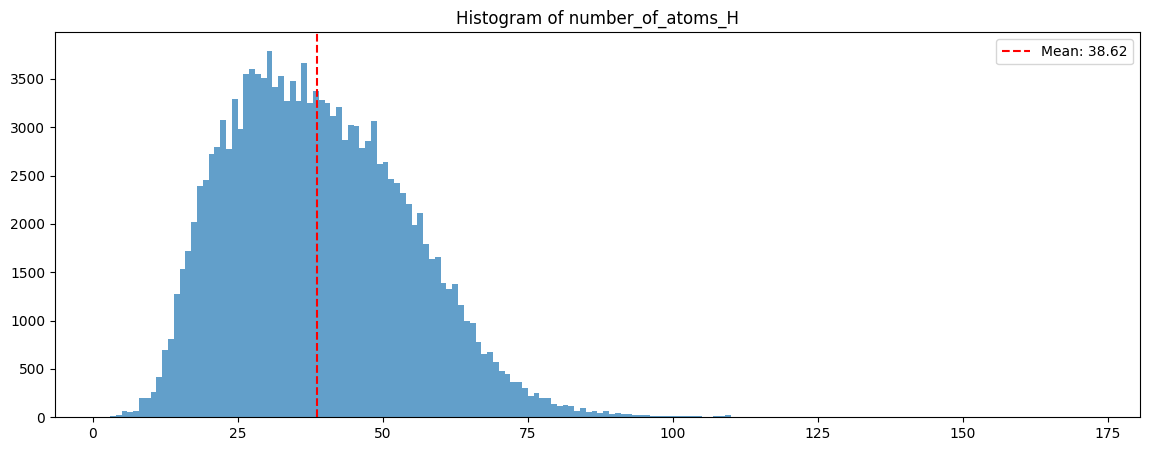

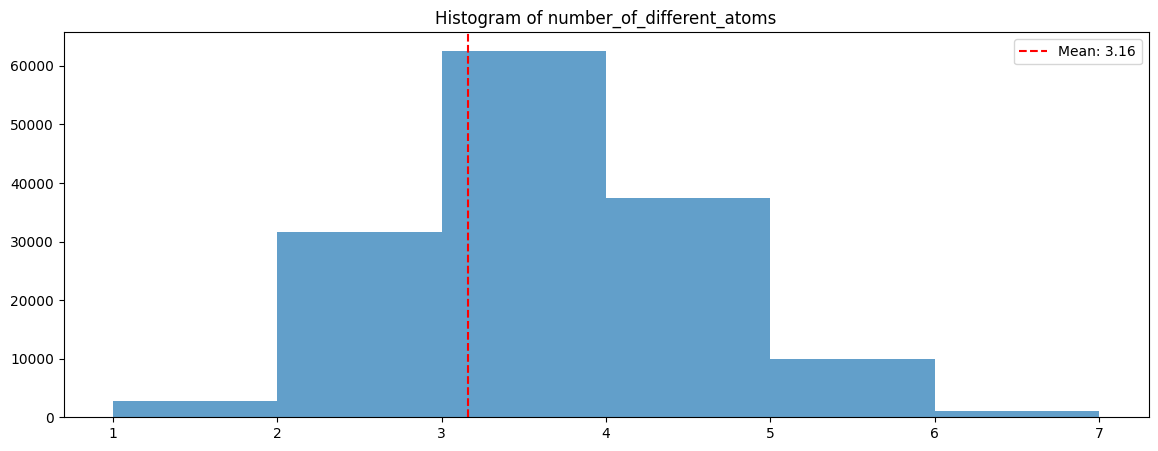

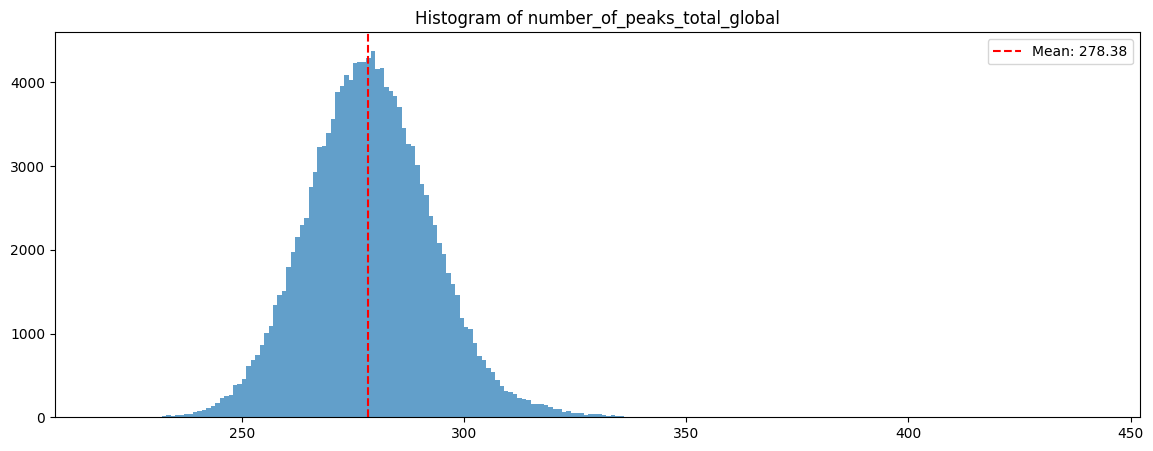

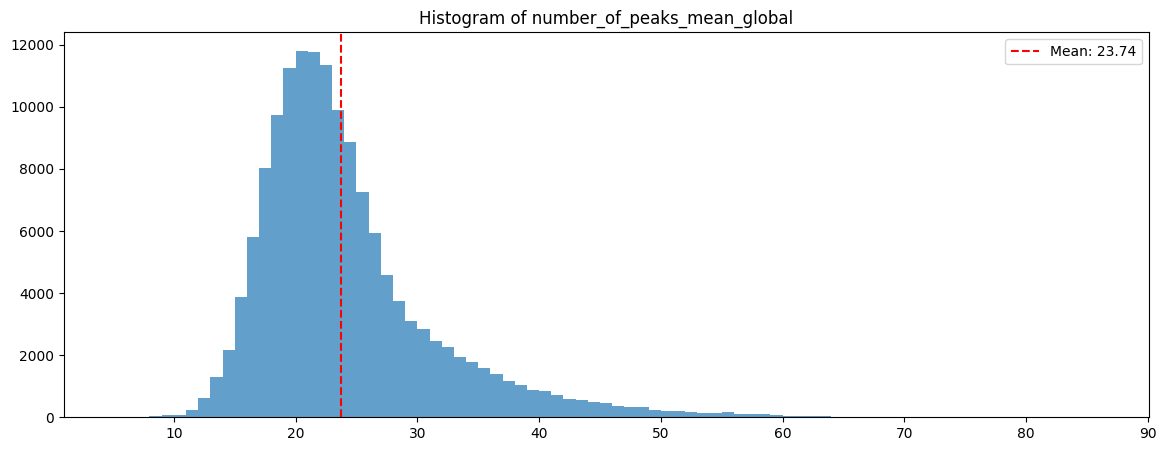

In [7]:
for col in ['number_of_atoms_H', 'number_of_different_atoms', 'number_of_peaks_total_global', 'number_of_peaks_mean_global']:

    plt.figure(figsize=(14,5))
    plt.hist(df[col], bins=range(df[col].min(), df[col].max()), alpha=0.7)
    plt.title(f'Histogram of {col}')
    plt.axvline(df[col].mean(), color='red', linestyle='dashed', label=f'Mean: {df[col].mean():.2f}')
    plt.legend()
    plt.plot()

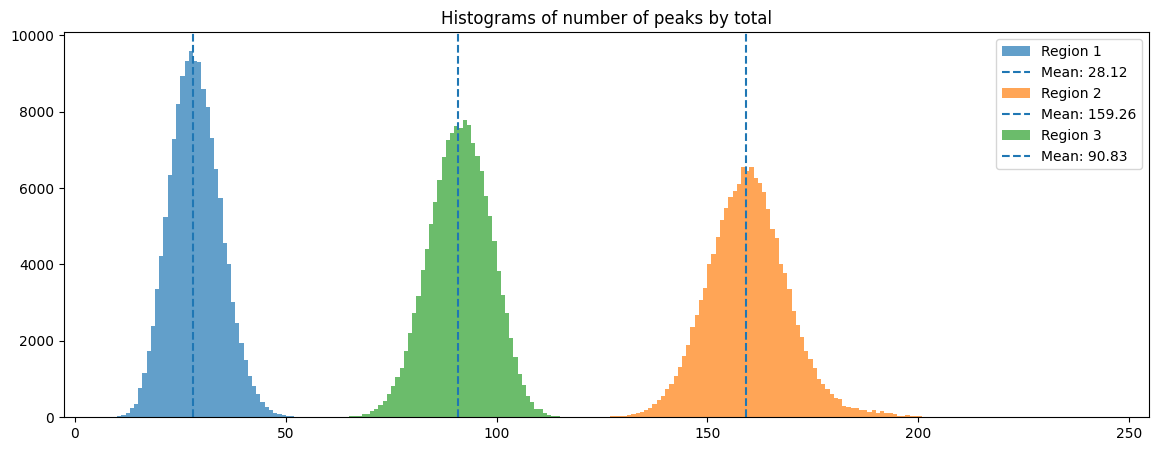

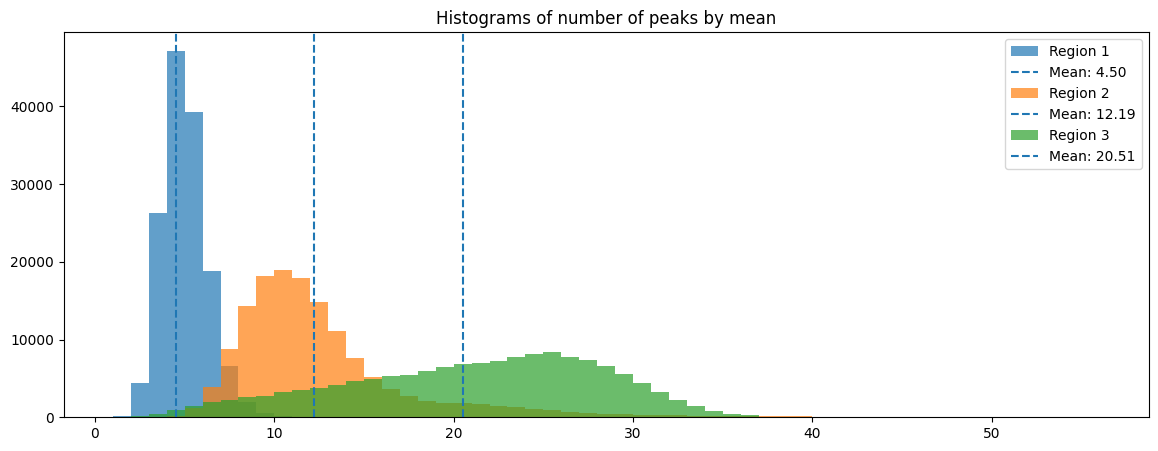

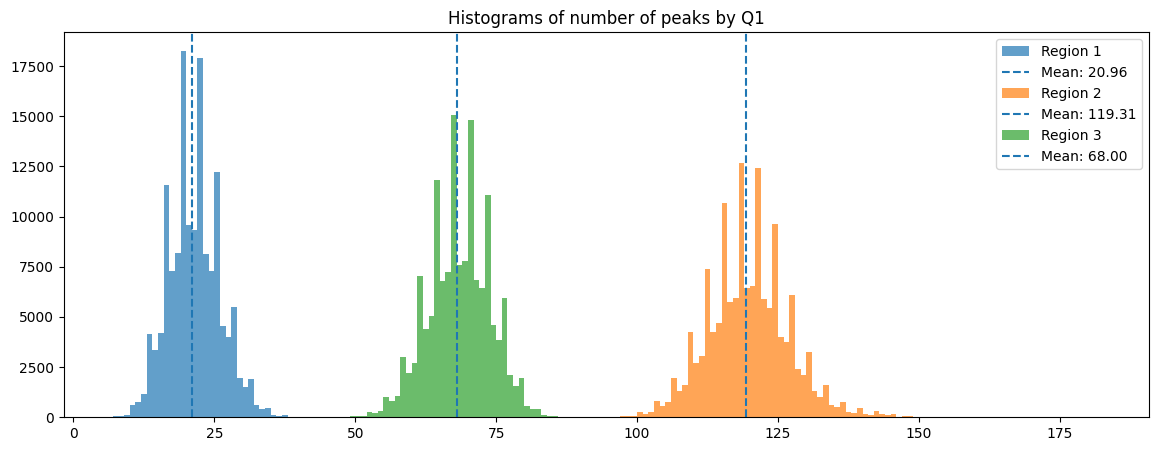

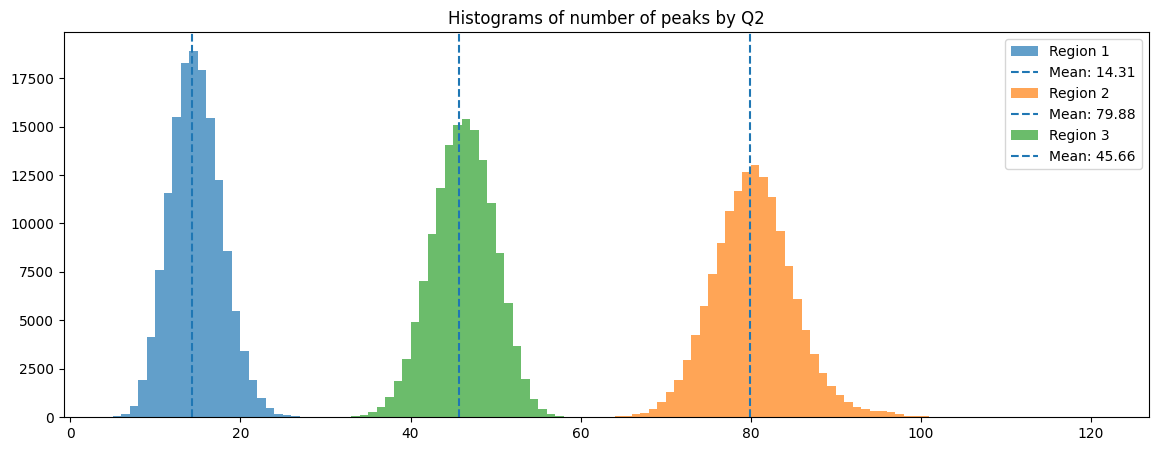

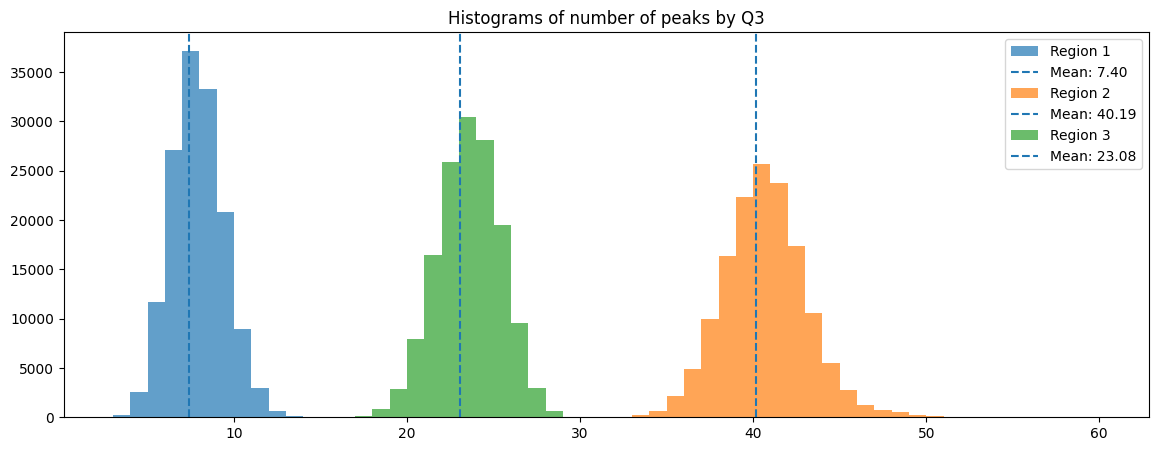

In [8]:
for threshold in ['total', 'mean', 'Q1', 'Q2', 'Q3']:
    
    plt.figure(figsize=(14,5))
    plt.title(f'Histograms of number of peaks by {threshold}')

    for i in range(1,4):
        
        col = f'number_of_peaks_{threshold}_R{i}'

        plt.hist(df[col], bins=range(df[col].min(), df[col].max()), alpha=0.7, label=f'Region {i}')
        
        plt.axvline(df[col].mean(), linestyle='dashed', label=f'Mean: {df[col].mean():.2f}')
        plt.legend()
        plt.plot()

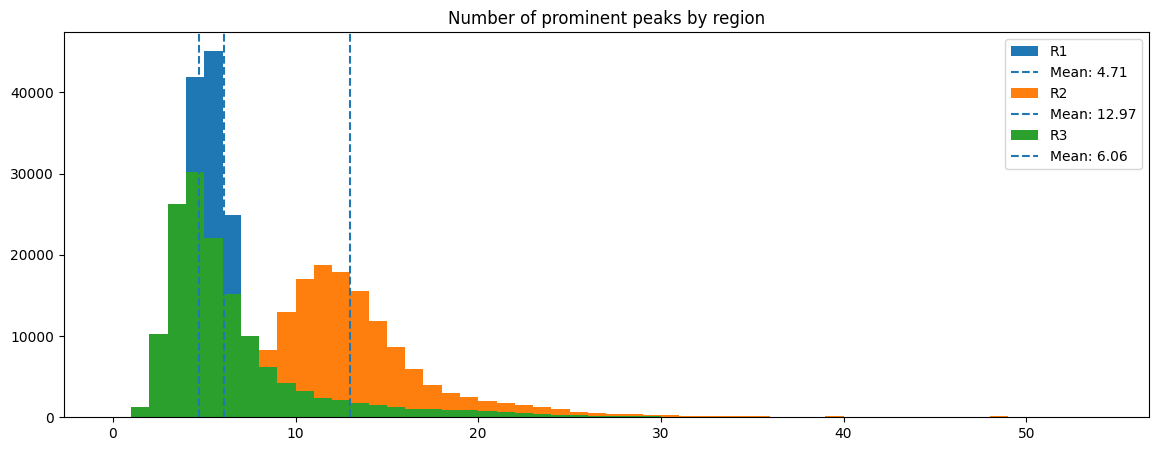

In [9]:
plt.figure(figsize=(14,5))
plt.title('Number of prominent peaks by region')

for i_region in range(1,4):

    col_name = f'number_of_prominent_peaks_in_R{i_region}'

    plt.hist(df[col_name], bins=range(df[col_name].min(), df[col_name].max()), label = f'R{i_region}')

    plt.axvline(df[col_name].mean(), linestyle='dashed', label=f'Mean: {df[col_name].mean():.2f}')
    plt.legend()
    plt.plot()
    

## Spectrum vizualization


In [10]:
df.head()

,smiles,labels,smile_length,smile_tokenized,smile_encoded,number_of_atoms,number_of_atoms_H,number_of_different_atoms,number_of_peaks_total_R1,number_of_peaks_mean_R1,...,number_of_peaks_Q2_R3,number_of_peaks_Q3_R3,number_of_peaks_total_global,number_of_peaks_mean_global,number_of_peaks_Q1_global,number_of_peaks_Q2_global,number_of_peaks_Q3_global,number_of_prominent_peaks_in_R1,number_of_prominent_peaks_in_R2,number_of_prominent_peaks_in_R3
0,COC(=O)c1ccc(NC(=O)Cn2c(-c3nnc(CC(C)C)o3)cc3cc...,"[0.0003184128493057, 0.0003199769547261, 0.000...",55,"[12, 16, 19, 16, 17, 22, 19, 18, 15, 20, 15, 1...","[0.011323273181915283, -0.10035507380962372, -...",32,56,3,29,5,...,44,22,281,22,211,141,71,5,13,4
1,CC#CCC,"[0.0008985671695786, 0.0009036991001202, 0.000...",6,"[12, 16, 16, 38, 16, 16, 16, 13]","[0.07150043547153473, 0.0067918673157691956, -...",5,13,1,33,4,...,45,23,289,40,217,145,73,3,17,20
2,COc1ccc([N+](=O)[O-])ccc1=O,"[0.0005838001141566, 0.0005795020293389, 0.000...",27,"[12, 16, 19, 15, 20, 15, 15, 15, 17, 23, 17, 2...","[-0.03448670357465744, 0.12521012127399445, 0....",13,20,3,26,4,...,54,27,305,22,229,153,77,5,14,3
3,CN(C)c1ccc(C=Nn2c(-c3ccccn3)n[nH]c2=S)cc1,"[0.0004524026321237, 0.0004516050609554, 0.000...",41,"[12, 16, 23, 17, 16, 18, 15, 20, 15, 15, 15, 1...","[-0.0695473924279213, -0.08500546962022781, -0...",23,39,3,36,5,...,40,20,276,23,207,138,69,4,13,6
4,c1ccc(C2=NCCN=C2c2ccccc2)cc1,"[0.0009248795716908, 0.0009355058962562, 0.000...",28,"[12, 15, 20, 15, 15, 15, 17, 16, 21, 22, 23, 1...","[0.14959512650966644, 0.2240678369998932, 0.04...",18,32,2,21,5,...,46,23,270,25,202,135,68,6,13,6


In [11]:
df.iloc[0:2]

,smiles,labels,smile_length,smile_tokenized,smile_encoded,number_of_atoms,number_of_atoms_H,number_of_different_atoms,number_of_peaks_total_R1,number_of_peaks_mean_R1,...,number_of_peaks_Q2_R3,number_of_peaks_Q3_R3,number_of_peaks_total_global,number_of_peaks_mean_global,number_of_peaks_Q1_global,number_of_peaks_Q2_global,number_of_peaks_Q3_global,number_of_prominent_peaks_in_R1,number_of_prominent_peaks_in_R2,number_of_prominent_peaks_in_R3
0,COC(=O)c1ccc(NC(=O)Cn2c(-c3nnc(CC(C)C)o3)cc3cc...,"[0.0003184128493057, 0.0003199769547261, 0.000...",55,"[12, 16, 19, 16, 17, 22, 19, 18, 15, 20, 15, 1...","[0.011323273181915283, -0.10035507380962372, -...",32,56,3,29,5,...,44,22,281,22,211,141,71,5,13,4
1,CC#CCC,"[0.0008985671695786, 0.0009036991001202, 0.000...",6,"[12, 16, 16, 38, 16, 16, 16, 13]","[0.07150043547153473, 0.0067918673157691956, -...",5,13,1,33,4,...,45,23,289,40,217,145,73,3,17,20


In [27]:
def plot_smile(line, save=False, save_path='fig'):
    
    smile = line['smiles']
    spectrum = np.array(line['labels'])

    mol = Chem.Draw.MolToImage(Chem.MolFromSmiles(smile))

    fig, ax = plt.subplots(figsize=(10, 4))

    xticks = 400 + 2*np.array(range(len(spectrum)))
    plt.plot(xticks, spectrum, label="true spectrum", alpha=1.0, linewidth=2)

    # 2D-Mol graph
    x, y = 2500, spectrum.max() / 1.5
    im = OffsetImage(mol, zoom=0.4, zorder=10)
    ab = AnnotationBbox(im, (x, y), frameon=False)
    ax.add_artist(ab)

    plt.title(smile)

    plt.xlabel("wavenumbers (cm$^{-1}$)")
    plt.xticks()
    plt.ylabel("absorbance (a.u.)")


    if save:
        plt.savefig(save_path+f'/{smile}.png')

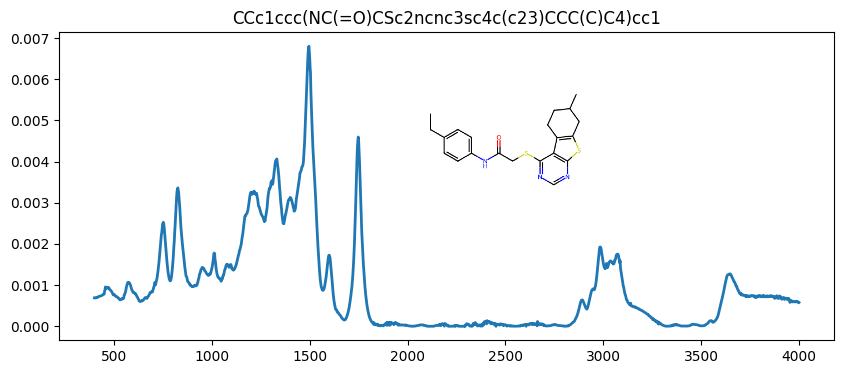

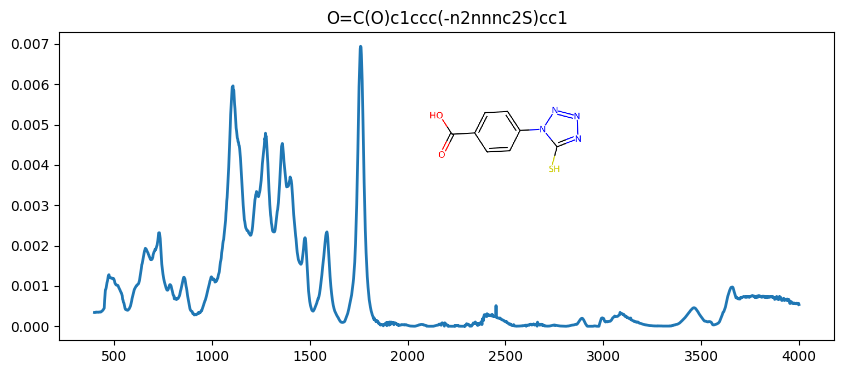

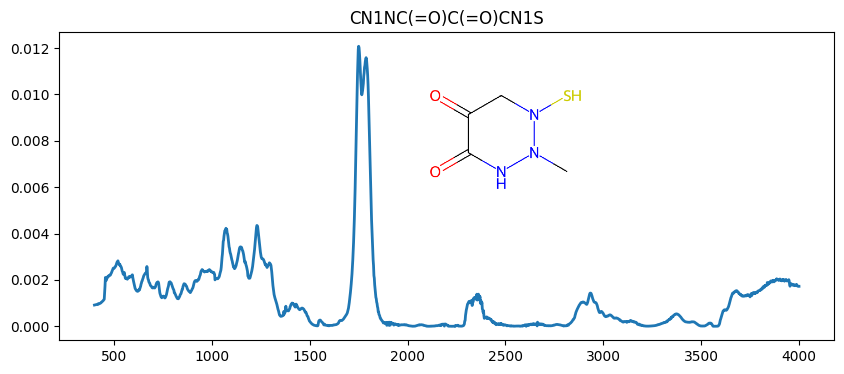

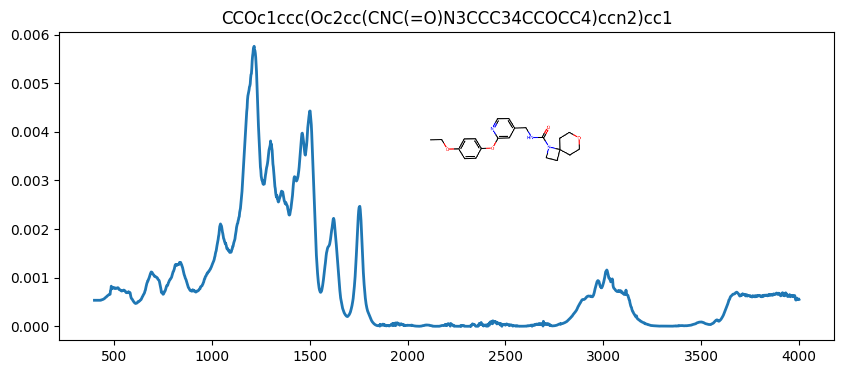

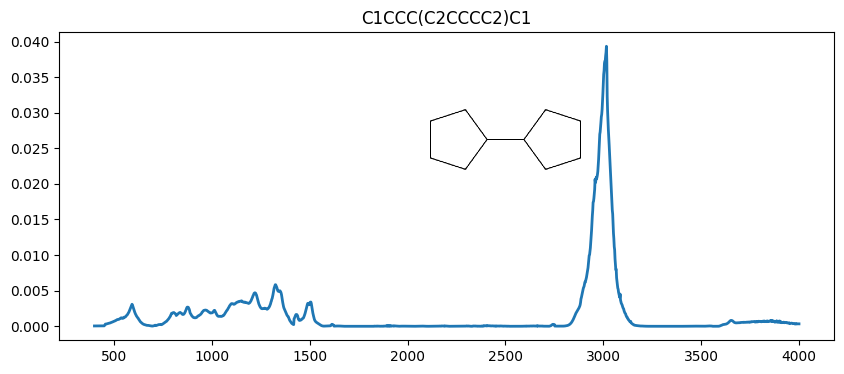

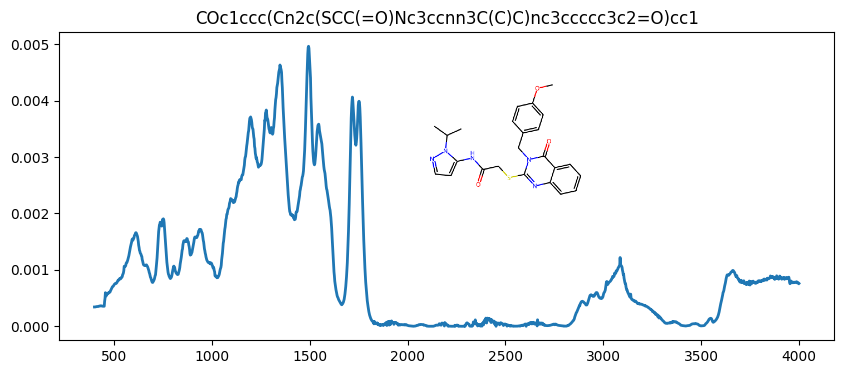

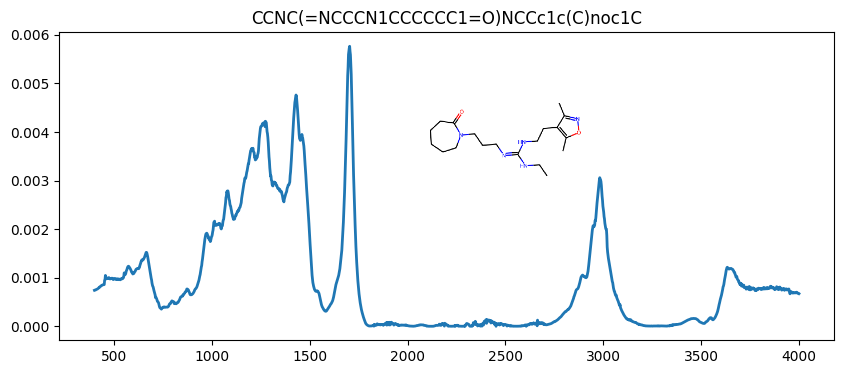

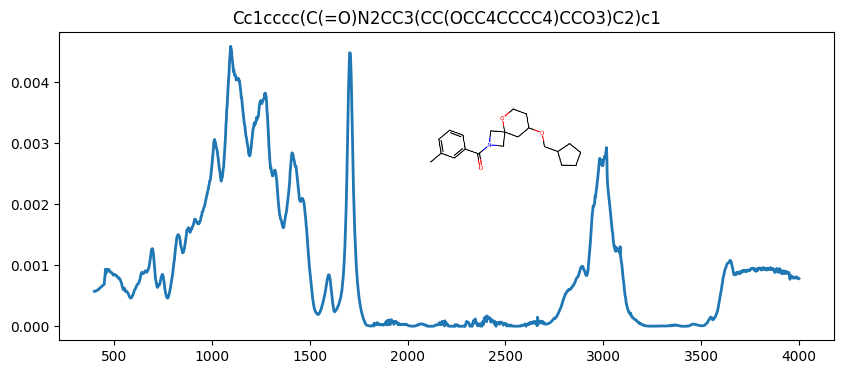

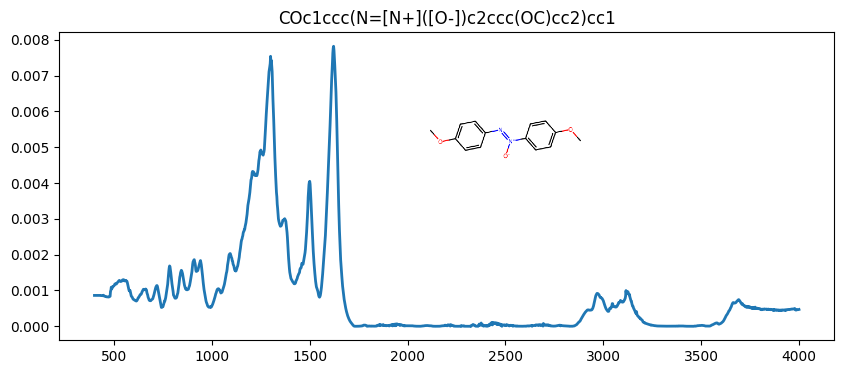

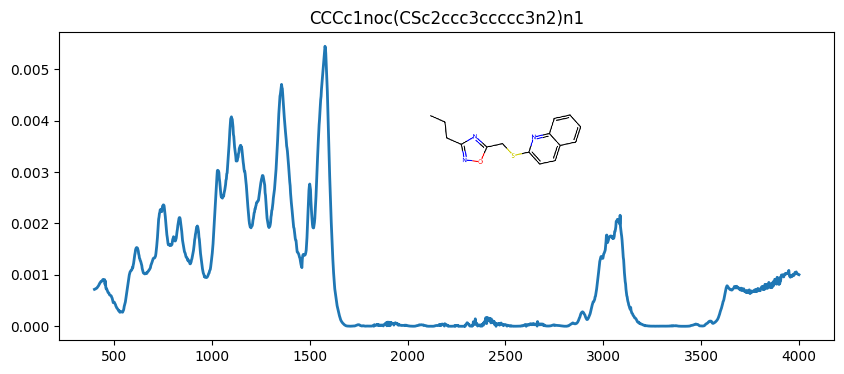

In [28]:
for idx in rd.sample(sorted(df.index), 10):
    plot_smile(df.iloc[idx], save=True)